# Core Workflow: Train 3-Category Classifier
Use the latest and greatest model structures, parameters, workflow (ie class weighting, learning fast & slow, etc) to train a 3-category classifier using only the non-road training samples.
  
Date: 2018-12-05  
Author: Full team

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Add, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

#ULU_REPO = os.environ["ULU_REPO"]
#sys.path.append(ULU_REPO+'/utils')
sys.path.append('/home/Peter.Kerins/UrbanLandUse/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow
import util_keras


Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
data_root='/data/phase_iii/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=5  # Lx:15 S2:10

s1_bands=['vv','vh']; s1_suffix='VVVH'
s1_resolution = resolution

ndvi_bands = ['raw'];

tile_resolution = resolution
tile_size = 256
tile_pad = 16

# ground truth source: aue, aue+osm, aue+osm2
label_suffix = 'aue'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Specify training data & training parameters

In [3]:
window = 17

cats_map = {}
cats_map[0] = 0
cats_map[1] = 1
cats_map[2] = 4
cats_map[3] = 4
cats_map[4] = 4
cats_map[5] = 4
cats_map[6] = 6

bands_vir=bands[:-1]
bands_sar=None
bands_ndvi=ndvi_bands
bands_ndbi=None
bands_osm=None

haze_removal = False


epochs = 500
batch_size = 128
balancing = None

In [4]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+ndvi 7


### Build training data "superset"
The "superset" of training data used to actually train a model can be a combination of any number of stored training data sets built from particular input stacks. These constituent sets can come from one or many cities. The only requirement is that they are all consistent in construction, ie are built from the same input stack.

In [5]:
reload(util_workflow)
place_images = {}

place_images['hyderabad'] = ['P','Q','R','S','T','U']

X_train_raw, Y_train_raw, X_valid_raw, Y_valid_raw = util_workflow.load_datasets(place_images, data_root, label_suffix, stack_label, window, resolution=resolution)

calculate total size of training and validation supersets
/data/phase_iii/hyderabad/hyderabad_train_aue_5m_vir+ndvi_17w_P.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue_5m_vir+ndvi_17w_P.pkl
(223806, 2023) (223806,) (95918, 2023) (95918,)
/data/phase_iii/hyderabad/hyderabad_train_aue_5m_vir+ndvi_17w_Q.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue_5m_vir+ndvi_17w_Q.pkl
(223806, 2023) (223806,) (95918, 2023) (95918,)
/data/phase_iii/hyderabad/hyderabad_train_aue_5m_vir+ndvi_17w_R.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue_5m_vir+ndvi_17w_R.pkl
(223806, 2023) (223806,) (95918, 2023) (95918,)
/data/phase_iii/hyderabad/hyderabad_train_aue_5m_vir+ndvi_17w_S.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue_5m_vir+ndvi_17w_S.pkl
(223806, 2023) (223806,) (95918, 2023) (95918,)
/data/phase_iii/hyderabad/hyderabad_train_aue_5m_vir+ndvi_17w_T.pkl
/data/phase_iii/hyderabad/hyderabad_valid_aue_5m_vir+ndvi_17w_T.pkl
(223806, 2023) (223806,) (95918, 2023) (95918,)
/data/phase_iii/hydera

### Scale training data

In [6]:
X_train_raw_scaled, X_valid_raw_scaled, scaler = util_ml.scale_learning_data(X_train_raw, X_valid_raw)
print X_train_raw_scaled.shape,  X_valid_raw_scaled.shape

(1342836, 2023) (575508, 2023)
(1342836, 2023) (575508, 2023)


In [7]:
del X_train_raw, X_valid_raw

In [8]:
X_train = X_train_raw_scaled.reshape((X_train_raw_scaled.shape[0],feature_count,window,window))
X_valid = X_valid_raw_scaled.reshape((X_valid_raw_scaled.shape[0],feature_count,window,window))
#print(X_train_raw[0])
#print(X_train[0])

In [9]:
del X_train_raw_scaled, X_valid_raw_scaled

In [10]:
print X_train.shape

(1342836, 7, 17, 17)


### Prepare training data for ingestion
This version of the workflow does not include class-balancing

Remap original set of categories (from the Atlas of Urban Expansion) encoded in the ground-truth files and the training data files to a target typology (eg collapsing all residential LULC types to a single category)

In [11]:
Y_train = Y_train_raw.copy()
Y_valid = Y_valid_raw.copy()

In [12]:
for k, v in cats_map.items():
    Y_train[Y_train_raw==k] = v
    Y_valid[Y_valid_raw==k] = v
    
print Y_train_raw.shape
print Y_train.shape

(1342836,)
(1342836,)


In [13]:
del Y_train_raw, Y_valid_raw

Remove roads

In [14]:
non_roads = np.where(Y_train!=6)
Y_train = Y_train[non_roads]
X_train = X_train[non_roads]
non_roads = np.where(Y_valid!=6)
Y_valid = Y_valid[non_roads]
X_valid = X_valid[non_roads]

Now reduce the remapped values to the categorical values required by the Keras library. These pre-processing steps could be consolidated, but represent two separate conceptual parts of the workflow, so are executed separately

In [15]:
Y_t = Y_train.copy()
Y_v = Y_valid.copy()

Y_t[Y_train==0] = 0
Y_t[Y_train==1] = 1
Y_t[Y_train==4] = 2
Y_t[Y_train==6] = 3

Y_v[Y_valid==0] = 0
Y_v[Y_valid==1] = 1
Y_v[Y_valid==4] = 2
Y_v[Y_valid==6] = 3

Change Y data to one-hot structure

In [16]:
categories_reduced = [0,1,2]

Y_t_cat = to_categorical(Y_t)
Y_v_cat = to_categorical(Y_v)

In [17]:
print Y_t.shape
print Y_t_cat.shape

(1154574,)
(1154574, 3)


### Build convolutional neural network

In [18]:
print("DEFAULT:",K.image_data_format())
K.set_image_data_format('channels_first')
print("UPDATED:",K.image_data_format())

('DEFAULT:', 'channels_last')
('UPDATED:', 'channels_first')


In [19]:
NB_FILTERS_1=32
NB_FILTERS_2=64

Name and briefly describe model

In [20]:
model_id = '3cat_Hyd_P-U'
notes = 'testing 3-category, 5m, bilinear, normal groundtruth, green images from 2017 for Hyderabad'

weights [1.3213210783520501, 1.6672451813132962, 1.0]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7, 17, 17)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 17, 17)   5632        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 17, 17)   2048        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 17, 17)   0           conv2d_1[0][0]                   
_______________________________________________________

Train on 1154574 samples, validate on 495114 samples
Epoch 1/500
1154574/1154574 [==============================] - 310s 269us/step - loss: 0.5697 - acc: 0.8258 - val_loss: 0.3162 - val_acc: 0.9101
Epoch 2/500
1154574/1154574 [==============================] - 295s 256us/step - loss: 0.3331 - acc: 0.9026 - val_loss: 0.2481 - val_acc: 0.9316
Epoch 3/500
1154574/1154574 [==============================] - 295s 256us/step - loss: 0.2895 - acc: 0.9160 - val_loss: 0.2086 - val_acc: 0.9391
Epoch 4/500
1154574/1154574 [==============================] - 295s 256us/step - loss: 0.2693 - acc: 0.9224 - val_loss: 0.1952 - val_acc: 0.9459
Epoch 5/500
1154574/1154574 [==============================] - 295s 256us/step - loss: 0.2589 - acc: 0.9257 - val_loss: 0.1821 - val_acc: 0.9475
Epoch 6/500
1154574/1154574 [==============================] - 295s 255us/step - loss: 0.2524 - acc: 0.9282 - val_loss: 0.1880 - val_acc: 0.9469


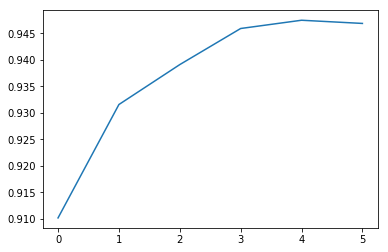

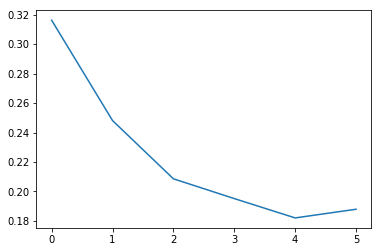

In [21]:
reload(util_ml)

weights = util_ml.generate_category_weights(place_images,category_label,label_suffix,stack_label,window,data_root,use_log=True,
                                   columns=['image_name','Open Space','Non-Residential','Residential-Total'],resolution=resolution)
print 'weights', weights
loss = util_keras.weighted_categorical_crossentropy(weights)

weights_label='WCC_weights.best'
callbacks, history_path = util_keras.create_callbacks(data_root, model_id, weights_label=weights_label, patience=1)
network=util_keras.build_model(util_keras.doubleres_block,input_shape=X_train.shape[-3:],output_nodes=len(categories_reduced))
util_keras.compile_network(network, loss, LR=0.001)

# train fast
history_fast = network.fit(X_train, Y_t_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_v_cat), shuffle=True,callbacks=callbacks)

plt.plot(history_fast.history['val_acc'])
plt.show()
plt.plot(history_fast.history['val_loss'])
plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 7, 17, 17)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 17, 17)   5632        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 17, 17)   2048        input_2[0][0]                    
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 32, 17, 17)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation

1154574/1154574 [==============================] - 298s 258us/step - loss: 0.1777 - acc: 0.9478 - val_loss: 0.1341 - val_acc: 0.9606
Epoch 2/500
1154574/1154574 [==============================] - 296s 257us/step - loss: 0.1579 - acc: 0.9533 - val_loss: 0.1276 - val_acc: 0.9625
Epoch 3/500
1154574/1154574 [==============================] - 295s 256us/step - loss: 0.1487 - acc: 0.9557 - val_loss: 0.1226 - val_acc: 0.9635
Epoch 4/500
1154574/1154574 [==============================] - 293s 254us/step - loss: 0.1438 - acc: 0.9572 - val_loss: 0.1200 - val_acc: 0.9642
Epoch 5/500
1154574/1154574 [==============================] - 293s 254us/step - loss: 0.1382 - acc: 0.9588 - val_loss: 0.1180 - val_acc: 0.9650
Epoch 6/500
1154574/1154574 [==============================] - 293s 254us/step - loss: 0.1354 - acc: 0.9596 - val_loss: 0.1144 - val_acc: 0.9656
Epoch 7/500
1154574/1154574 [==============================] - 293s 254us/step - loss: 0.1318 - acc: 0.9608 - val_loss: 0.1114 - val_acc: 0.96

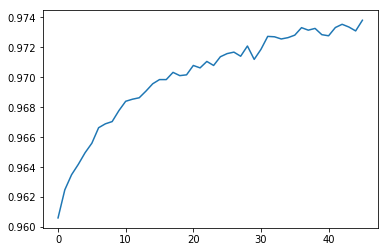

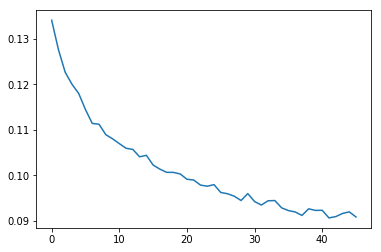

In [22]:
# rebuild network
network=util_keras.build_model(util_keras.doubleres_block,input_shape=X_train.shape[-3:],output_nodes=len(categories_reduced))
# load weights from fast learning
filepath = data_root+'models/'+model_id+'_'+weights_label+'.hdf5'
network.load_weights(filepath)
weights_label='WCC_weights_slow.best'
callbacks, history_path = util_keras.create_callbacks(data_root, model_id, weights_label=weights_label, patience=3)
util_keras.compile_network(network, loss, LR=0.0001)

# train slow
history_slow = network.fit(X_train, Y_t_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_v_cat),shuffle=True,callbacks=callbacks)

plt.plot(history_slow.history['val_acc'])
plt.show()
plt.plot(history_slow.history['val_loss'])
plt.show()

In [25]:
print "evaluate training"
Yhat_t_prob = network.predict(X_train)
Yhat_t = Yhat_t_prob.argmax(axis=-1)
train_confusion = util_ml.calc_confusion(Yhat_t,Y_t,categories_reduced)
train_recalls, train_precisions, train_accuracy = util_ml.calc_confusion_details(train_confusion)


# Calculate f-score
beta = 2
train_f_score = (beta**2 + 1) * train_precisions * train_recalls / ( (beta**2 * train_precisions) + train_recalls )
train_f_score_open = train_f_score[0] 
train_f_score_nonres = train_f_score[1]  
train_f_score_res = train_f_score[2]  
train_f_score_roads = None#train_f_score[3]  
train_f_score_average = np.mean(train_f_score)


print "evaluate validation"
Yhat_v_prob = network.predict(X_valid)
Yhat_v = Yhat_v_prob.argmax(axis=-1)
valid_confusion = util_ml.calc_confusion(Yhat_v,Y_v,categories_reduced)
valid_recalls, valid_precisions, valid_accuracy = util_ml.calc_confusion_details(valid_confusion)

# Calculate f-score
valid_f_score = (beta**2 + 1) * valid_precisions * valid_recalls / ( (beta**2 * valid_precisions) + valid_recalls )
valid_f_score_open = valid_f_score[0] 
valid_f_score_nonres = valid_f_score[1] 
valid_f_score_res = valid_f_score[2] 
valid_f_score_roads = None# valid_f_score[3] 
valid_f_score_average = np.mean(valid_f_score)


# expanding lists to match expected model_record stuff
train_recalls_expanded = [train_recalls[0],train_recalls[1],train_recalls[2],None]
valid_recalls_expanded = [valid_recalls[0],valid_recalls[1],valid_recalls[2],None]
train_precisions_expanded = [train_precisions[0],train_precisions[1],train_precisions[2],None]
valid_precisions_expanded = [valid_precisions[0],valid_precisions[1],valid_precisions[2],None]

evaluate training
0 370788
1 293856
2 489930
[[366774   2327   1687]
 [  1177 292314    365]
 [  2673    858 486399]]
1154574 1145487 0.9921295646706058
evaluate validation
0 157830
1 126792
2 210492
[[152583   2972   2275]
 [  2408 123324   1060]
 [  2974   1278 206240]]
495114 482147 0.9738100720238168


In [26]:
scaler_filename = data_root+'models/'+model_id+'_scaler.pkl'
#model_filename  = data_root+'models/'+model_id+'_SVM.pkl'
network_filename = data_root+'models/'+model_id+'DLv3.hd5'

if os.path.exists(scaler_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+scaler_filename+')'
#elif os.path.exists(model_filename):
#    print 'Aborting all pickle operations: file already exists at specified path ('+model_filename+')'
elif os.path.exists(network_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+network_filename+')'
else:
    print scaler_filename
#    print model_filename
    print network_filename
    pickle.dump(scaler, open(scaler_filename, 'wb'))
#    pickle.dump(model, open(model_filename, 'wb'))
    network.save(network_filename)
    # tracking only occurs if all saves are successful
    util_workflow.record_model_creation(
        model_id, notes, place_images, label_suffix, resolution, stack_label, feature_count, window, cats_map, balancing, 
        network.get_config(), epochs, batch_size,
        train_confusion, train_recalls_expanded, train_precisions_expanded, train_accuracy,
        train_f_score_open, train_f_score_nonres, train_f_score_res, train_f_score_roads, train_f_score_average,
        valid_confusion, valid_recalls_expanded, valid_precisions_expanded, valid_accuracy,
        valid_f_score_open, valid_f_score_nonres, valid_f_score_res, valid_f_score_roads, valid_f_score_average,)

/data/phase_iii/models/3cat_Hyd_P-U_scaler.pkl
/data/phase_iii/models/3cat_Hyd_P-UDLv3.hd5
